(excess_deaths)=
# Counterfactual inference: calculating excess deaths due to Covid-19

:::{post} July, 2022
:tags: counterfactuals, causal inference, time series, case study, Bayesian workflow, forecasting, causal impact
:category: intermediate
:author: Benjamin T. Vincent
:::

Causal reasoning and counterfactual thinking are really interesting but complex topics! Nevertheless, we can make headway into understanding the ideas through relatively simple examples. This notebook focusses on the concepts and the practical implementation of Bayesian causal reasoning using PyMC.

We do this using the sobering but important example of calculating excess deaths due to Covid-19. As such, the ideas in this notebook strongly overlap with Google's [CausalImpact](https://google.github.io/CausalImpact/CausalImpact.html) (see {cite:t}`google_causal_impact2015`). Practically, we will try to estimate the number of 'excess deaths' since the onset of Covid-19, using data from England and Wales. Excess deaths are defined as:

$$
\text{Excess deaths} = 
  \underbrace{\text{Reported Deaths}}_{\text{noisy measure of actual deaths}} 
  - \underbrace{\text{Expected Deaths}}_{\text{unmeasurable counterfactual}}
$$

Making a claim about excess deaths requires causal/counterfactual reasoning. While the reported number of deaths is nothing but a (maybe noisy and/or lagged) measure of a real observable fact in the world, _expected deaths_ is unmeasurable because these are never realised in our timeline. That is, the expected deaths is a counterfactual thought experiment where can ask "What would/will happen if?"

## Overall strategy
How do we go about this, practically? We will follow this strategy:
1. Import data on reported number of deaths from all causes (our outcome variable), as well as a few reasonable predictor variables: 
    - average monthly temperature
    - month of the year, which we use to model seasonal effects
    - and time which is used to model any underlying linear trend.
2. Split into `pre` and `post` covid datasets. This is an important step. We want to come up with a model based upon what we know _before_ Covid-19 so that we can construct our counterfactual predictions based on data before Covid-19 had any impact.
3. Estimate model parameters based on the `pre` dataset. From this we can calculate the number of deaths expected by the model in the pre Covid-19 period. This is not a counterfactual, but acts to tell us how capable the model is at accounting for the already observed data.
4. Counterfactual inference - we use our model to construct a counterfactual forecast. What would we expect to see in the future if there was no Covid-19? Practically, we do this with posterior prediction on out-of-sample data. 
5. Calculate the excess deaths by comparing the reported deaths with our counterfactual (expected number of deaths).

## Modelling strategy
We could take many different approaches to the modelling. Because we are dealing with time series data, then it would be very sensible to use a time series modelling approach. For example, Google's [CausalImpact](https://google.github.io/CausalImpact/CausalImpact.html) uses a [Bayesian structural time-series](https://en.wikipedia.org/wiki/Bayesian_structural_time_series) model, but there are many alternative time series models we could choose. 

But because the focus of this case study is on the counterfactual reasoning rather than the specifics of time-series modelling, I chose the simpler approach of linear regression for time-series model (see {cite:t}`martin2021bayesian` for more on this).

## Causal inference disclaimer

Readers should be aware that there are of course limits to the causal claims we can make here. If we were dealing with a marketing example were we ran a promotion for a period of time and wanted to make inferences about _excess sales_, then we could only make strong causal claims if we had done our due diligence in accounting for other factors which may have also taken place during our promotion period. 

Similarly, there are [many other things that changed in the UK since January 2020](https://en.wikipedia.org/wiki/2020_in_the_United_Kingdom#Events) (the well documented time of the first Covid-19 cases) in England and Wales. So if we wanted to be rock solid then we should account for other feasibly relevant factors.

Finally, we are _not_ claiming that $x$ people died directly from the Covid-19 viris. The beauty of the concept of excess deaths is that it captures deaths from all causes that are in excess of what we would expect. As such, it covers not only those who died directly from the Covid-19 virus, but also from all downstream effects of the virus and availability of care, for example.

In [1]:
import calendar
import os

import aesara.tensor as at
import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import xarray as xr

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

Now let's define some helper functions

In [3]:
def format_x_axis(ax, minor=False):
    # major ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y %b"))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.grid(which="major", linestyle="-", axis="x")
    # minor ticks
    if minor:
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y %b"))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(which="minor", linestyle=":", axis="x")
    # rotate labels
    for label in ax.get_xticklabels(which="both"):
        label.set(rotation=70, horizontalalignment="right")


def plot_xY(x, Y, ax):
    quantiles = Y.quantile((0.025, 0.25, 0.5, 0.75, 0.975), dim=("chain", "draw")).transpose()

    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.025, 0.975]),
        fill_kwargs={"alpha": 0.25},
        smooth=False,
        ax=ax,
    )
    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.25, 0.75]),
        fill_kwargs={"alpha": 0.5},
        smooth=False,
        ax=ax,
    )
    ax.plot(x, quantiles.sel(quantile=0.5), color="C1", lw=3)


# default figure sizes
figsize = (10, 5)

# create a list of month strings, for plotting purposes
month_strings = calendar.month_name[1:]

## Import data
For our purposes we will obtain number of deaths (per month) reported in England and Wales. This data is available from the Office of National Statistics dataset [Deaths registered monthly in England and Wales](https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/monthlyfiguresondeathsregisteredbyareaofusualresidence). I manually downloaded this data for the years 2006-2022 and aggregated it into a single `.csv` file. Below we import this and create columns for the year, the month and the observation number.

In [4]:
try:
    df = pd.read_csv(os.path.join("..", "data", "total_deaths.csv"))
except FileNotFoundError:
    df = pd.read_csv(pm.get_data("total_deaths.csv"))

df = df.assign(
    date=pd.to_datetime(df["date"], format="%m-%Y"),
    year=lambda x: x["date"].dt.year,
    month=lambda x: x["date"].dt.month,
    t=df.index,
).set_index("date")
df["pre"] = df.index < "2020"
display(df)

,deaths,year,month,t,pre
date,,,,,
2006-01-01,49124,2006,1,0,True
2006-02-01,42664,2006,2,1,True
2006-03-01,49207,2006,3,2,True
2006-04-01,40645,2006,4,3,True
2006-05-01,42425,2006,5,4,True
...,...,...,...,...,...
2022-01-01,53158,2022,1,192,False
2022-02-01,45869,2022,2,193,False
2022-03-01,49489,2022,3,194,False


We are also going to use temperature data as a predictor. So below we import [average UK temperature from the Met Office](https://www.metoffice.gov.uk/research/climate/maps-and-data/uk-and-regional-series) by month and do some processing to get it into the right format.

In [5]:
try:
    w = pd.read_csv(os.path.join("..", "data", "weather.csv"))
except FileNotFoundError:
    w = pd.read_csv(pm.get_data("weather.csv"))

w = pd.melt(
    w,
    id_vars="year",
    value_vars=[
        "jan",
        "feb",
        "mar",
        "apr",
        "may",
        "jun",
        "jul",
        "aug",
        "sep",
        "oct",
        "nov",
        "dec",
    ],
    var_name="month",
    value_name="temp",
)
w["date"] = w["year"].map(str) + "-" + w["month"].map(str)
w["date"] = pd.to_datetime(w["date"])
w = w.drop(["month", "year"], axis=1).sort_values("date").set_index("date").dropna()
display(w)

,temp
date,
1884-01-01,5.0
1884-02-01,4.2
1884-03-01,5.1
1884-04-01,6.2
1884-05-01,9.7
...,...
2022-03-01,6.7
2022-04-01,8.1
2022-05-01,11.8


We merge these two data sources into a single dataframe.

In [6]:
df = w.merge(df, on="date", how="inner")
df = df.rename(columns={"temp_x": "temp"})
display(df)

,temp,deaths,year,month,t,pre
date,,,,,,
2006-01-01,3.8,49124,2006,1,0,True
2006-02-01,3.4,42664,2006,2,1,True
2006-03-01,3.9,49207,2006,3,2,True
2006-04-01,7.4,40645,2006,4,3,True
2006-05-01,10.7,42425,2006,5,4,True
...,...,...,...,...,...,...
2022-01-01,4.7,53158,2022,1,192,False
2022-02-01,5.6,45869,2022,2,193,False
2022-03-01,6.7,49489,2022,3,194,False


Finally, we split into `pre` and `post` Covid-19 onset dataframes. It is documented that the first Covid-19 cases appeared in the UK in January 2020, so we will take this time point as the cutoff for the pre vs. post Covid-19 era.

In [7]:
pre = df[df.index < "2020"]
post = df[df.index >= "2020"]

## Visualise data

### Reported deaths over time
Plotting the time series shows that there is clear seasonality in the number of deaths, and we can also take a guess that there may be an increase in the average number of deaths per year.

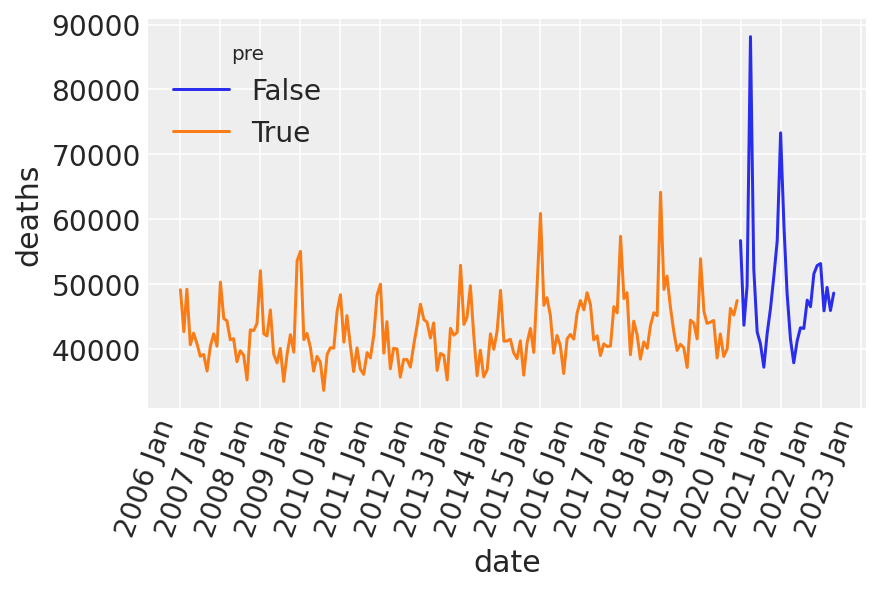

In [8]:
ax = sns.lineplot(data=df, x="date", y="deaths", hue="pre")
format_x_axis(ax)

### Seasonality

Let's take a closer look at the seasonal pattern (just of the pre-covid data) by plotting deaths as a function of month, and we will color code the year. This confirms our suspicion of a seasonal trend in numbers of deaths with there being more deaths in the winter season than the summer. We can also see a large number of deaths in January, followed by a slight dip in February which bounces back in March. This could be due to a combination of:
- `push-back` of deaths that actually occurred in December being registered in January
- or `pull-forward` where many of the vulnerable people who would have died in February ended up dying in January, potentially due to the cold conditions.

The colour coding supports our suspicion that there is a positive main effect of year - that the baseline number of deaths per year is increasing.

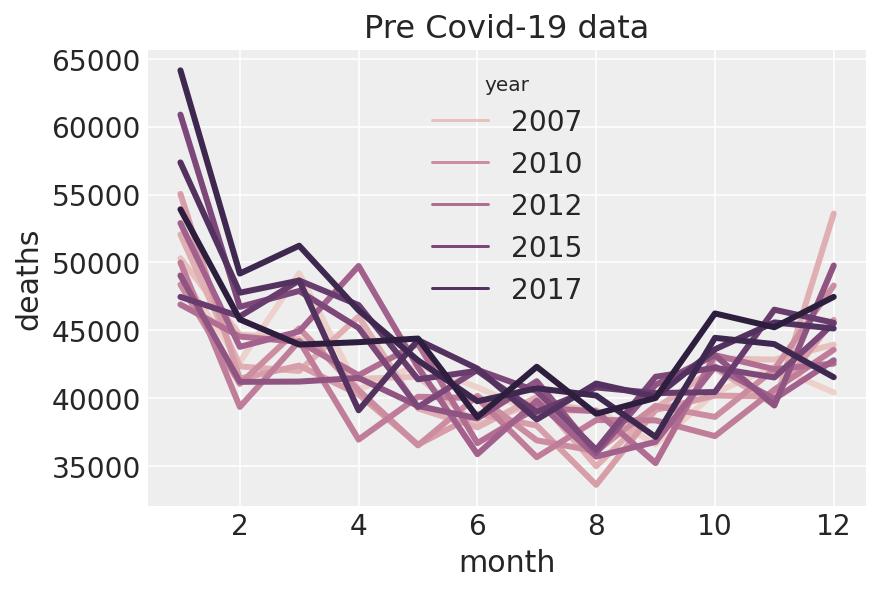

In [9]:
ax = sns.lineplot(data=pre, x="month", y="deaths", hue="year", lw=3)
ax.set(title="Pre Covid-19 data");

### Linear trend

Let's look at that more closely by plotting the total deaths over time, pre Covid-19. While there is some variability here, it seems like adding a linear trend as a predictor will capture some of the variance in reported deaths, and therefore make for a better model of reported deaths.

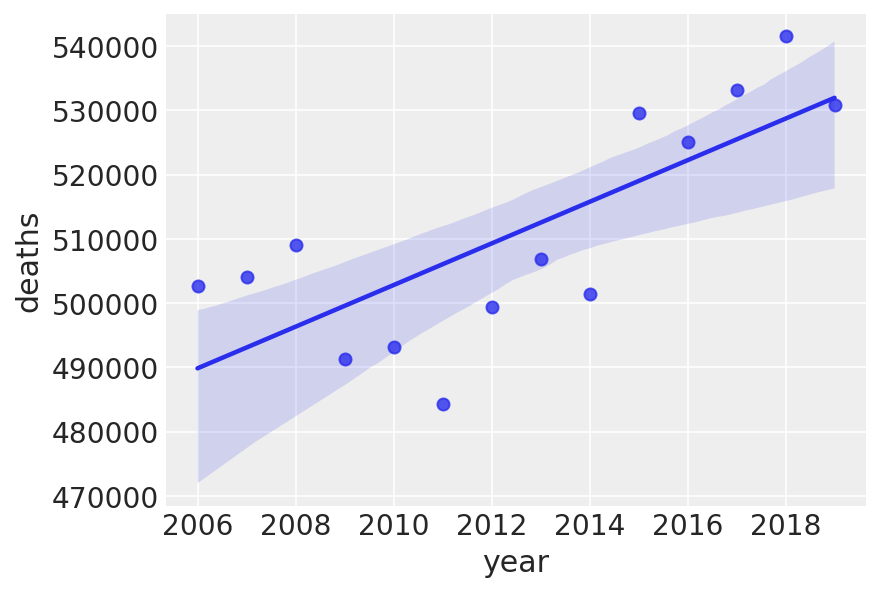

In [10]:
annual_deaths = pd.DataFrame(pre.groupby("year")["deaths"].sum()).reset_index()
sns.regplot(x="year", y="deaths", data=annual_deaths);

### Effects of temperature on deaths

Looking at the `pre` data alone, there is a clear negative relationship between monthly average temperature and the number of deaths. This relationship could plausibly be quadratic, but for our purposes a linear relationship seems like a reasonable place to start.

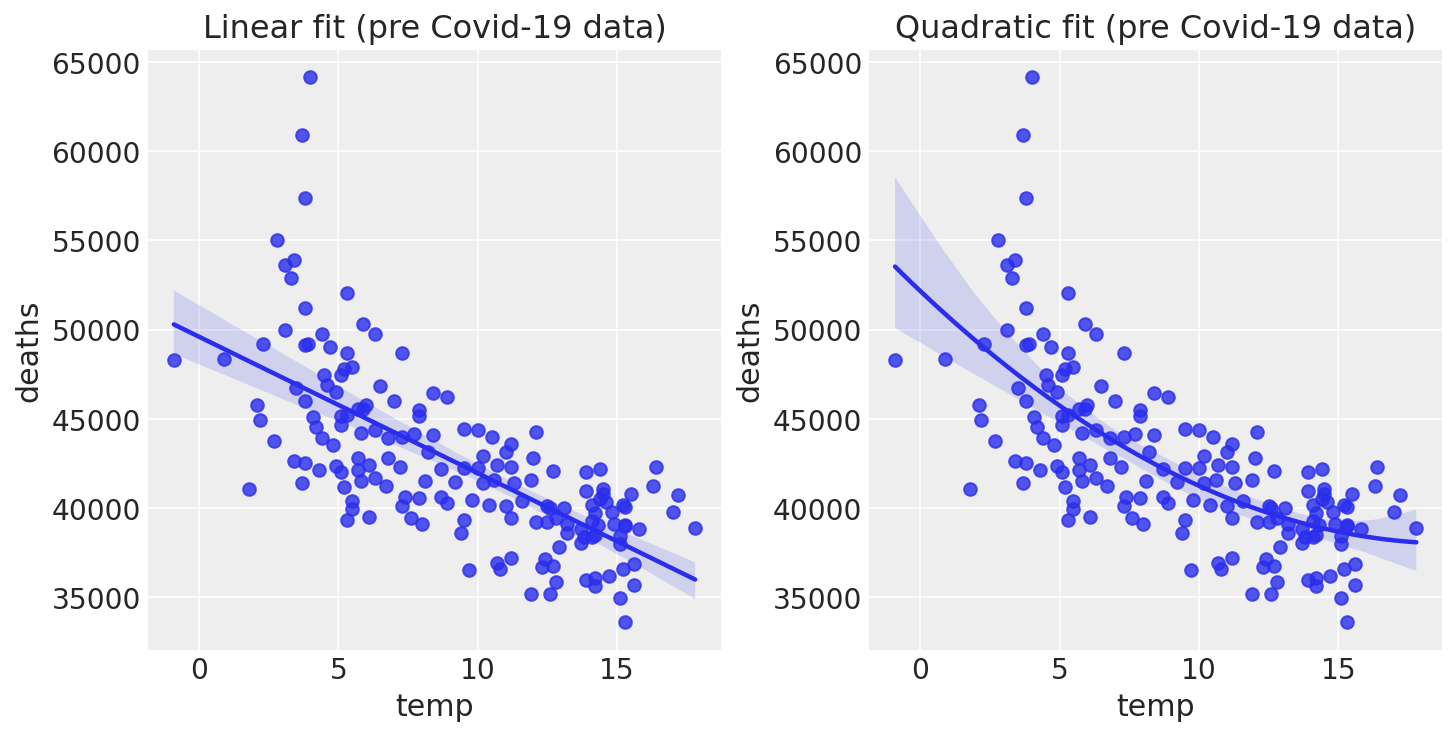

In [11]:
fig, ax = plt.subplots(1, 2, figsize=figsize)
sns.regplot(x="temp", y="deaths", data=pre, scatter_kws={"s": 40}, order=1, ax=ax[0])
ax[0].set(title="Linear fit (pre Covid-19 data)")
sns.regplot(x="temp", y="deaths", data=pre, scatter_kws={"s": 40}, order=2, ax=ax[1])
ax[1].set(title="Quadratic fit (pre Covid-19 data)");

Let's examine the slope of this relationship, which will be useful in defining a prior for a temperature coefficient in our model.

In [12]:
# NOTE: results are returned from higher to lower polynomial powers
slope, intercept = np.polyfit(pre["temp"], pre["deaths"], 1)
print(f"{slope:.0f} deaths/degree")

-764 deaths/degree


Based on this, if we focus only on the relationship between temperature and deaths, we expect there to be 764 _fewer_ deaths for every $1^\circ C$ increase in average monthly temperature. So we can use this figure when it comes to defining a prior over the coefficient for the temperature effect.

## Modelling

We are going to estimate reported deaths over time with an intercept, a linear trend, seasonal deflections (for each month), and average monthly temperature. So this is a pretty straightforward linear model. The only thing of note is that we transform the normally distributed monthly deflections to have a mean of zero in order to reduce the degrees of freedom of the model by one, which should help with parameter identifiability.

In [13]:
with pm.Model(coords={"month": month_strings}) as model:

    # observed predictors and outcome
    month = pm.MutableData("month", pre["month"].to_numpy(), dims="t")
    time = pm.MutableData("time", pre["t"].to_numpy(), dims="t")
    temp = pm.MutableData("temp", pre["temp"].to_numpy(), dims="t")
    deaths = pm.MutableData("deaths", pre["deaths"].to_numpy(), dims="t")

    # priors
    intercept = pm.Normal("intercept", 40_000, 10_000)
    _month_mu = pm.Normal("_month_mu", 0, 3000, dims="month")
    # remove a degree of freedom by subtracting mean
    month_mu = pm.Deterministic(
        "month mu",
        _month_mu - at.mean(_month_mu),
        dims="month",
    )
    linear_trend = pm.TruncatedNormal("linear trend", 0, 50, lower=0)
    temp_coeff = pm.Normal("temp coeff", 0, 200)

    # the actual linear model
    mu = pm.Deterministic(
        "mu",
        intercept + (linear_trend * time) + month_mu[month - 1] + (temp_coeff * temp),
        dims="t",
    )
    sigma = pm.HalfNormal("sigma", 2_000)
    # likelihood
    pm.TruncatedNormal("obs", mu=mu, sigma=sigma, lower=0, observed=deaths, dims="t")

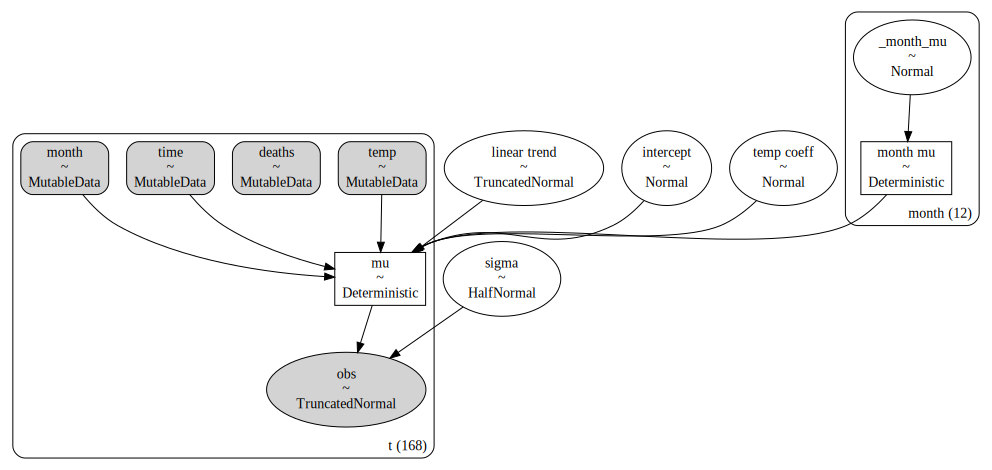

In [14]:
pm.model_to_graphviz(model)

## Prior predictive check

As part of the Bayesian workflow, we will plot our prior predictions to see what outcomes the model finds before having observed any data.

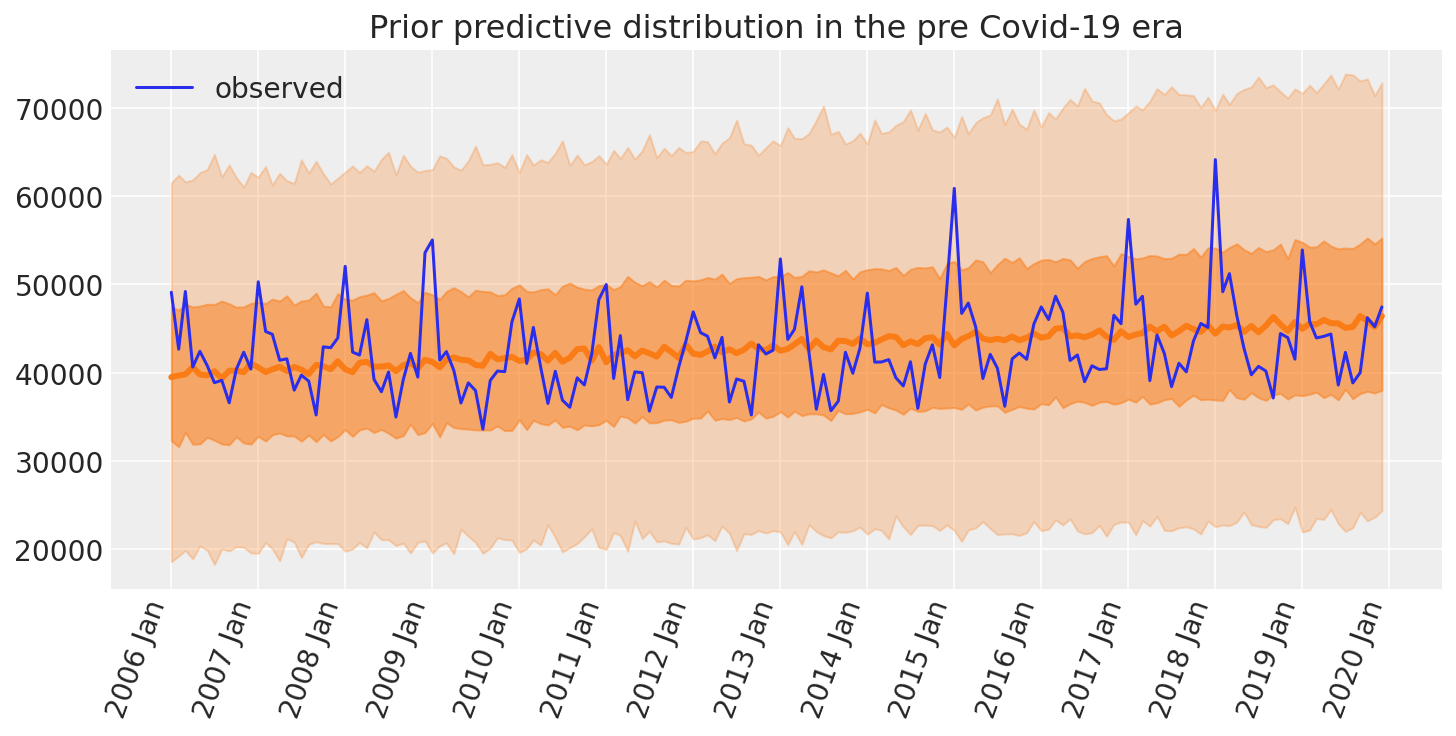

In [15]:
with model:
    idata = pm.sample_prior_predictive(random_seed=RANDOM_SEED)


fig, ax = plt.subplots(figsize=figsize)

plot_xY(pre.index, idata.prior_predictive["obs"], ax)
format_x_axis(ax)
ax.plot(pre.index, pre["deaths"], label="observed")
ax.set(title="Prior predictive distribution in the pre Covid-19 era")
plt.legend();

This seems reasonable:
- The _a priori_ number of deaths looks centred on the observed numbers.
- Given the priors, the predicted range of deaths is quite broad, and so is unlikely to over-constrain the model.
- The model does not predict negative numbers of deaths per month.

We can look at this in more detail with the Arviz prior predictive check (ppc) plot. Again we see that the distribution of the observations is centered on the actual observations but has more spread. This is useful as we know the priors are not too restrictive and are unlikely to systematically influence our posterior predictions upwards or downwards.

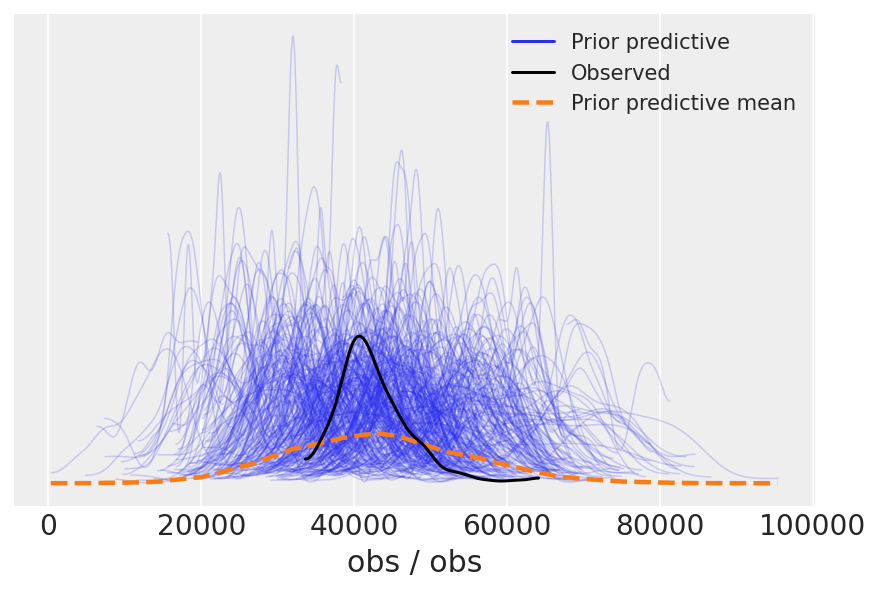

In [16]:
az.plot_ppc(idata, group="prior");

## Inference 
Draw samples for the posterior distribution, and remember we are doing this for the pre Covid-19 data only.

In [17]:
with model:
    idata.extend(pm.sample(tune=2000, target_accept=0.85, random_seed=RANDOM_SEED))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, _month_mu, linear trend, temp coeff, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 17 seconds.


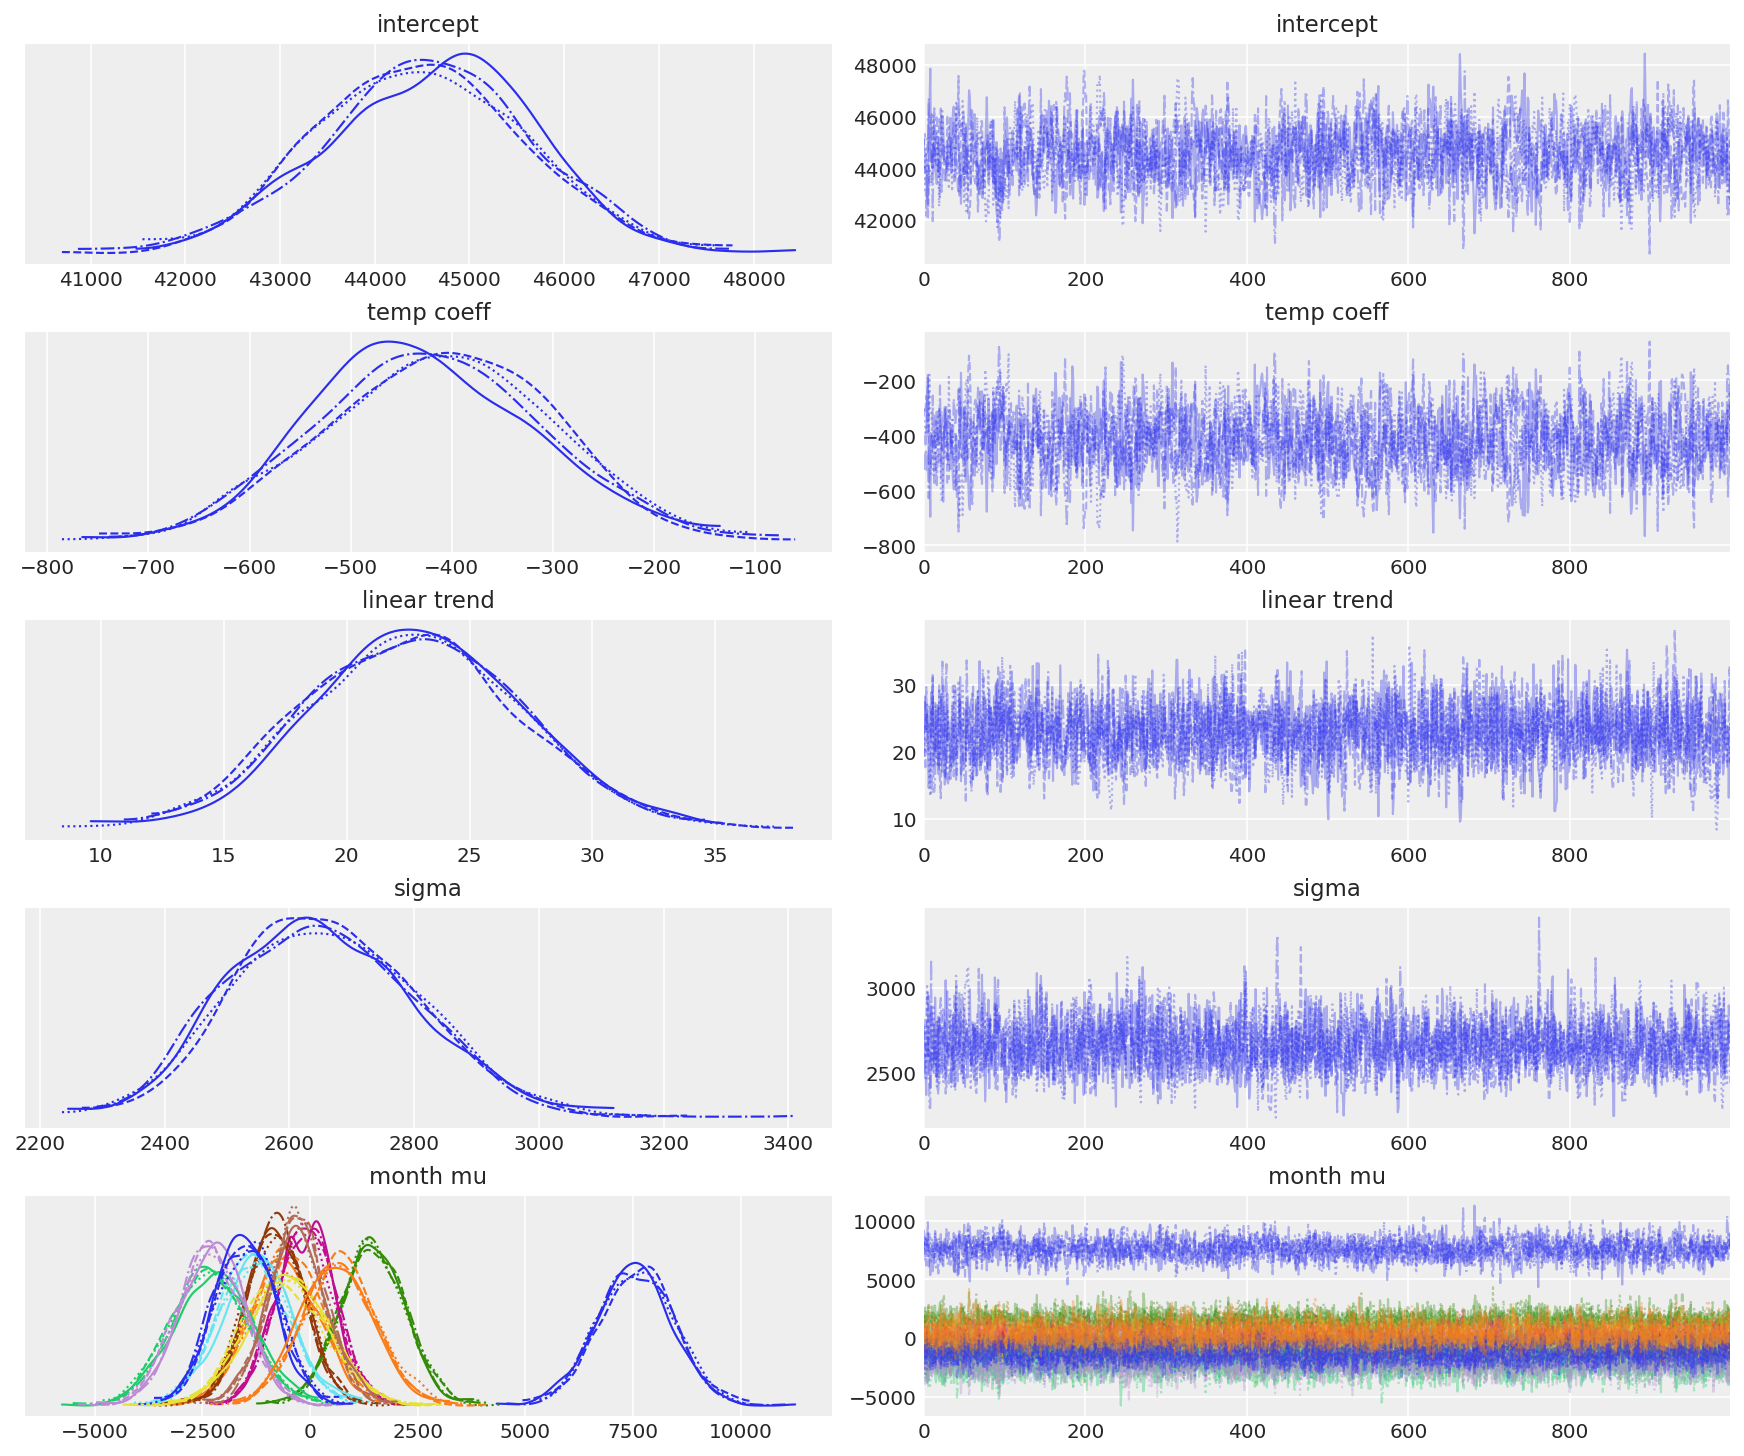

In [18]:
az.plot_trace(idata, var_names=["~mu", "~_month_mu"]);

Let's also look at the posterior estimates of the monthly deflections, in a different way to focus on the seasonal effect.

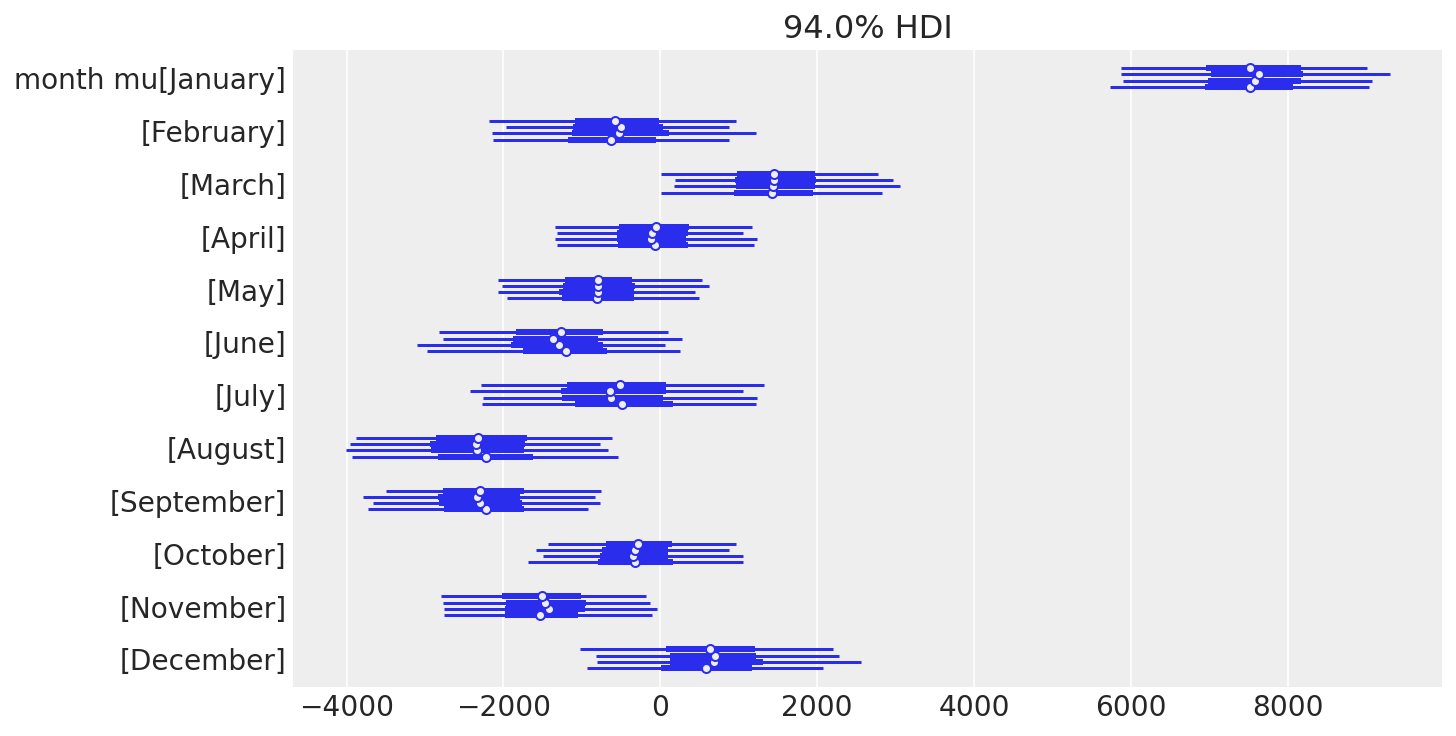

In [19]:
az.plot_forest(idata.posterior, var_names="month mu", figsize=figsize);

## Posterior predictive check

Another important aspect of the Bayesian workflow is to plot the model's posterior predictions, allowing us to see how well the model can account for the already observed data. It is at this point that we can decide whether the model is too simple (then we'd build more complexity into the model) or if it's fine.

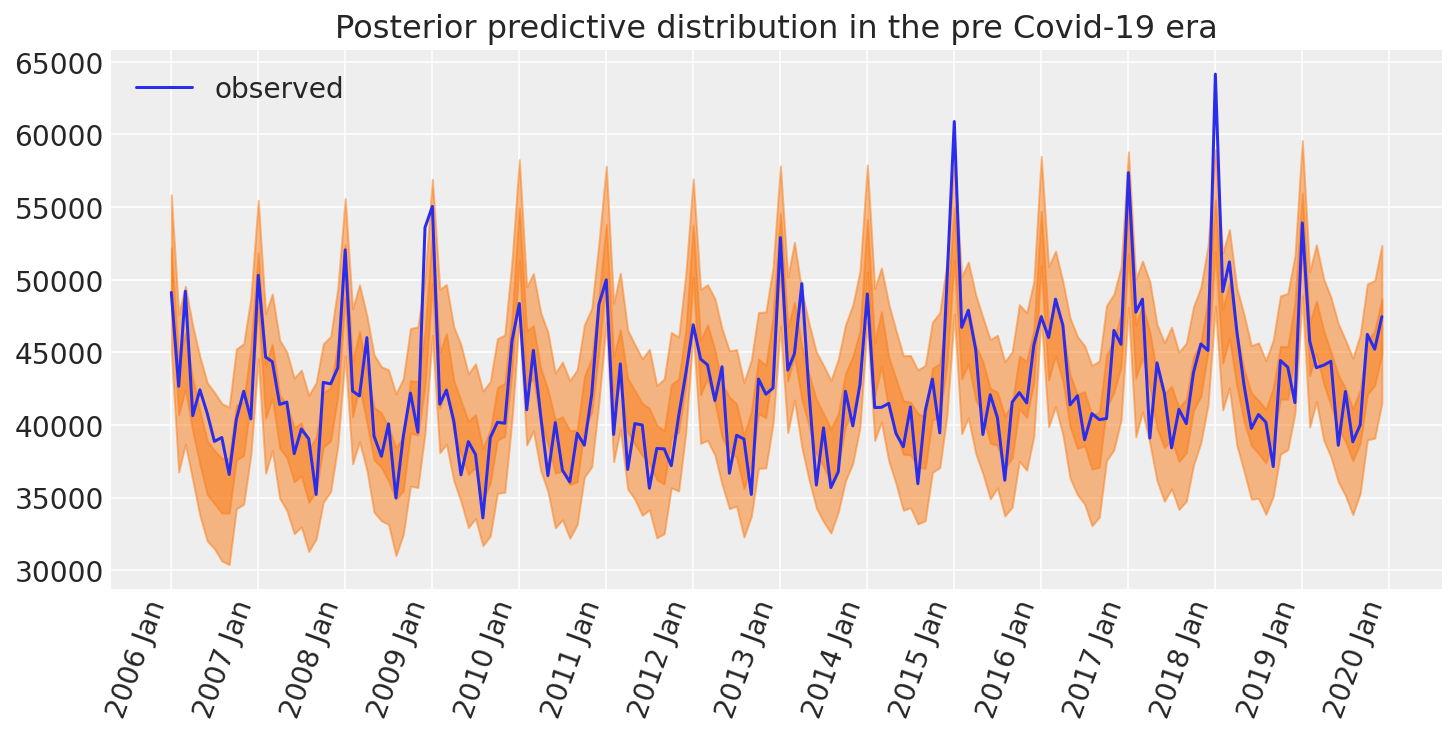

In [20]:
with model:
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=RANDOM_SEED))


fig, ax = plt.subplots(figsize=figsize)

az.plot_hdi(pre.index, idata.posterior_predictive["obs"], hdi_prob=0.5, smooth=False)
az.plot_hdi(pre.index, idata.posterior_predictive["obs"], hdi_prob=0.95, smooth=False)
ax.plot(pre.index, pre["deaths"], label="observed")
format_x_axis(ax)
ax.set(title="Posterior predictive distribution in the pre Covid-19 era")
plt.legend();

Let's do another check now, but focussing on the seasonal effect. We will replicate the plot that we had above of deaths as a function of month of the year. And in order to keep the plot from being a complete mess, we will just plot the posterior mean. As such this is not a posterior _predictive_ check, but a check of the posterior.

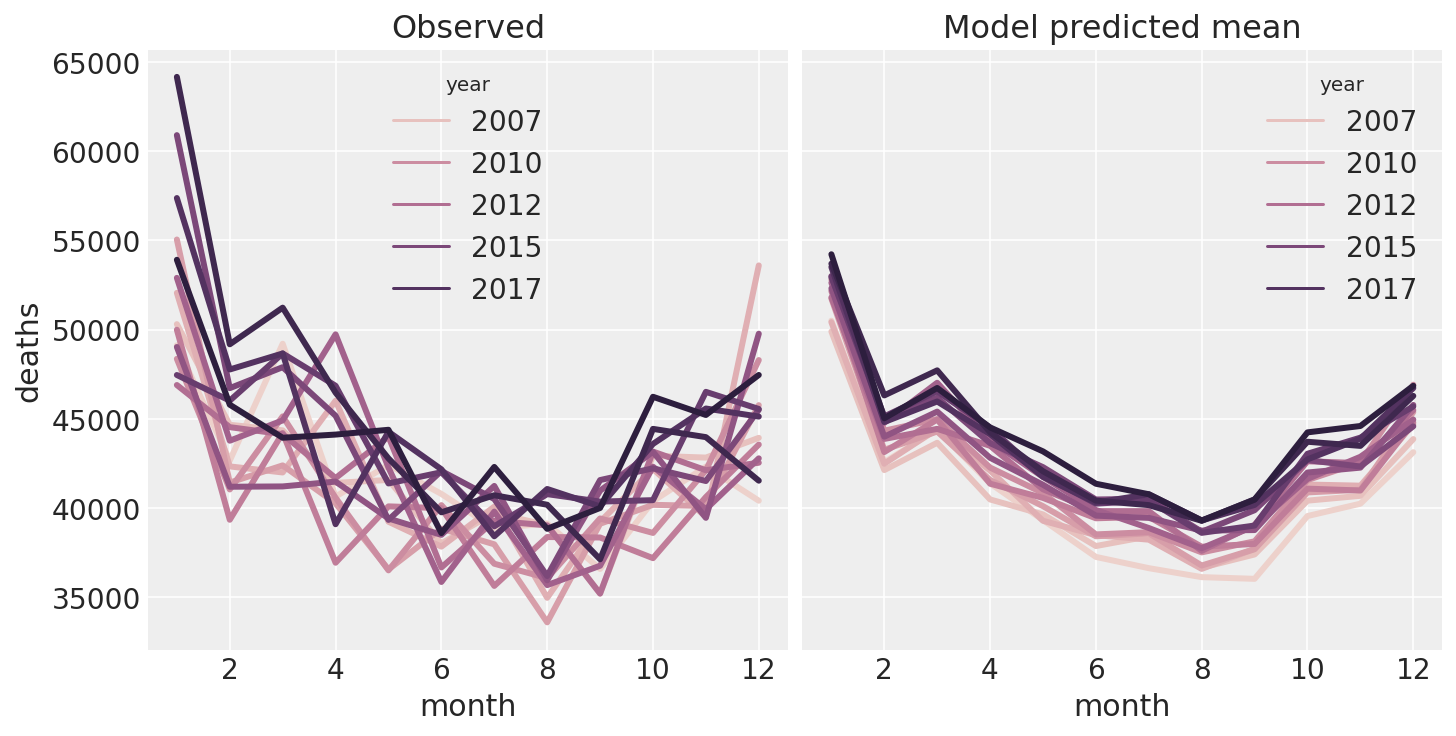

In [21]:
temp = idata.posterior["mu"].mean(dim=["chain", "draw"]).to_dataframe()
pre = pre.assign(deaths_predicted=temp["mu"].values)

fig, ax = plt.subplots(1, 2, figsize=figsize, sharey=True)
sns.lineplot(data=pre, x="month", y="deaths", hue="year", ax=ax[0], lw=3)
ax[0].set(title="Observed")
sns.lineplot(data=pre, x="month", y="deaths_predicted", hue="year", ax=ax[1], lw=3)
ax[1].set(title="Model predicted mean");

The model is doing a pretty good job of capturing the properties of the data. On the right, we can clearly see the main effects of `month` and `year`. However, we can see that there is something interesting happening in the data (left) in January which the model is not capturing. This might be able to be captured in the model by adding an interaction between `month` and `year`, but this is left as an exercise for the reader.

## Excess deaths: Pre-Covid

This step is not strictly necessary, but we can apply the excess deaths formula to the models' predictions for the `pre` period. This is useful because we can examine how good the model is. 

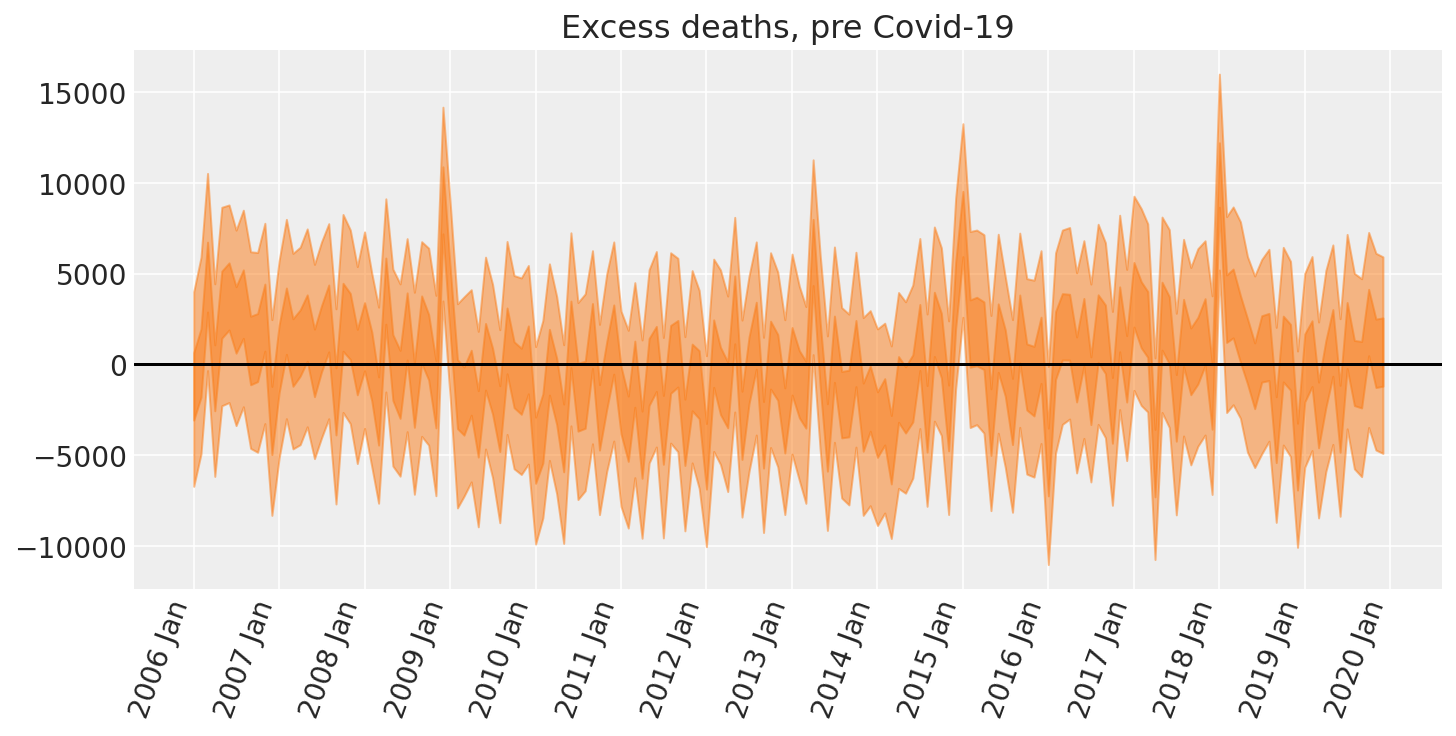

In [22]:
# convert deaths into an XArray object with a labelled dimension to help in the next step
deaths = xr.DataArray(pre["deaths"].to_numpy(), dims=["t"])

# do the calculation by taking the difference
excess_deaths = deaths - idata.posterior_predictive["obs"]

fig, ax = plt.subplots(figsize=figsize)
# the transpose is to keep arviz happy, ordering the dimensions as (chain, draw, t)
az.plot_hdi(pre.index, excess_deaths.transpose(..., "t"), hdi_prob=0.5, smooth=False)
az.plot_hdi(pre.index, excess_deaths.transpose(..., "t"), hdi_prob=0.95, smooth=False)
format_x_axis(ax)
ax.axhline(y=0, color="k")
ax.set(title="Excess deaths, pre Covid-19");

We can see that we have a few spikes here where the number of excess deaths is plausibly greater than zero. Such occasions are above and beyond what we could expect from: a) seasonal effects, b) the linearly increasing trend, b) the effect of cold winters. 

If we were interested, then we could start to generate hypotheses about what additional predictors may account for this. Some ideas could include the prevalence of the common cold, or minimum monthly temperatures which could add extra predictive information not captured by the mean.

We can also see that there is some additional temporal trend that the model is not quite capturing. There is some systematic low-frequency drift from the posterior mean from zero. That is, there is additional variance in the data that our predictors are not quite capturing which could potentially be caused by changes in the size of vulnerable cohorts over time.

But we are close to our objective of calculating excess deaths during the Covid-19 period, so we will move on as the primary purpose here is on counterfactual thinking, not on building the most comprehensive model of reported deaths ever.

## Counterfactual inference
Now we will use our model to predict the reported deaths in the 'what if?' scenario of business as usual.

So we update the model with the `month` and time (`t`) and `temp` data from the `post` dataframe and run posterior predictive sampling to predict the number of reported deaths we would observe in this counterfactual scenario. We could also call this 'forecasting'.

In [23]:
with model:
    pm.set_data(
        {
            "month": post["month"].to_numpy(),
            "time": post["t"].to_numpy(),
            "temp": post["temp"].to_numpy(),
        }
    )
    counterfactual = pm.sample_posterior_predictive(
        idata, var_names=["obs"], random_seed=RANDOM_SEED
    )

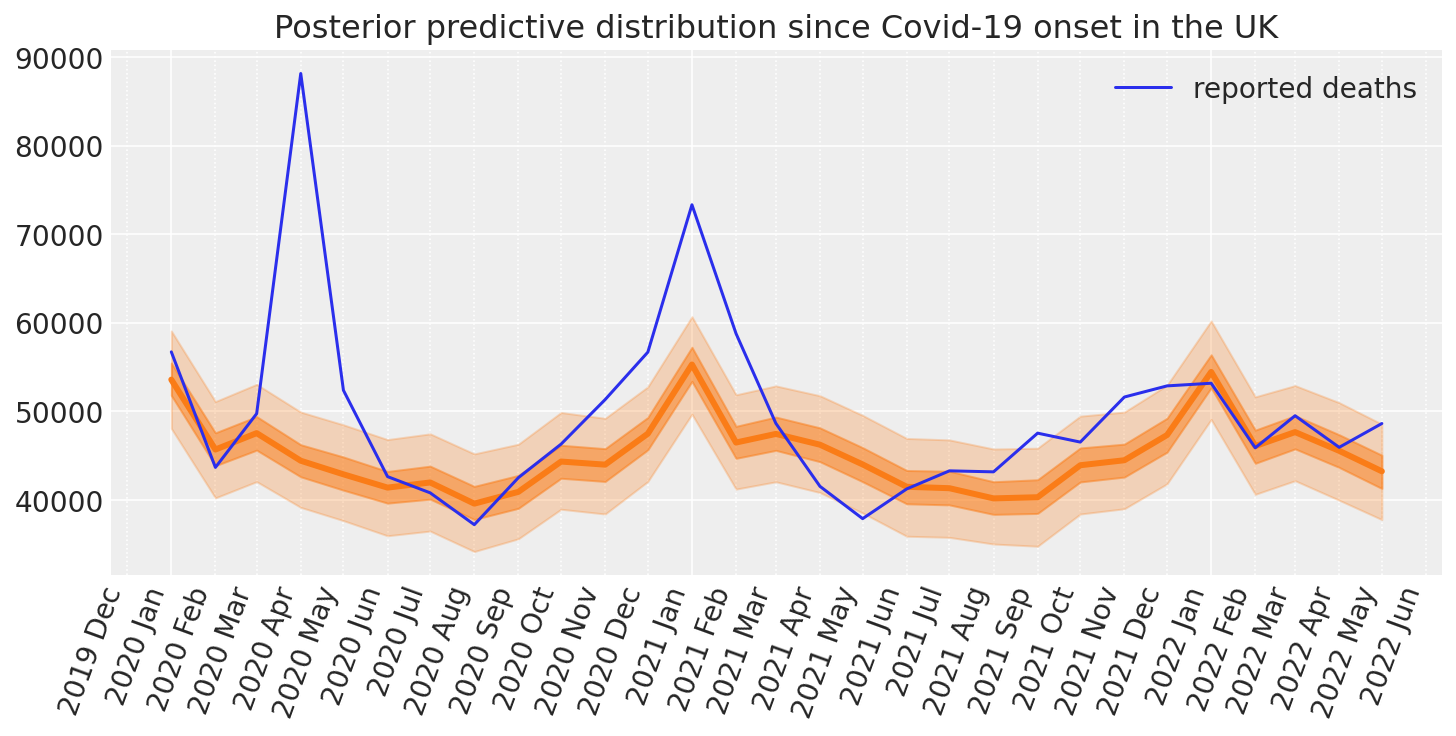

In [24]:
fig, ax = plt.subplots(figsize=figsize)

plot_xY(post.index, counterfactual.posterior_predictive["obs"], ax)
format_x_axis(ax, minor=True)
ax.plot(post.index, post["deaths"], label="reported deaths")
ax.set(title="Posterior predictive distribution since Covid-19 onset in the UK")
plt.legend();

We now have the ingredients needed to calculate excess deaths. Namely, the reported number of deaths, and the Bayesian counterfactual prediction of how many would have died if nothing had changed from the pre to post Covid-19 era.

## Excess deaths: since Covid onset

Now we'll use the predicted number of deaths under the counterfactual scenario and compare that to the reported number of deaths to come up with our counterfactual estimate of excess deaths.

In [25]:
# convert deaths into an XArray object with a labelled dimension to help in the next step
deaths = xr.DataArray(post["deaths"].to_numpy(), dims=["t"])

# do the calculation by taking the difference
excess_deaths = deaths - counterfactual.posterior_predictive["obs"]

And we can easily compute the cumulative excess deaths

In [26]:
# calculate the cumulative excess deaths
cumsum = excess_deaths.cumsum(dim="t")

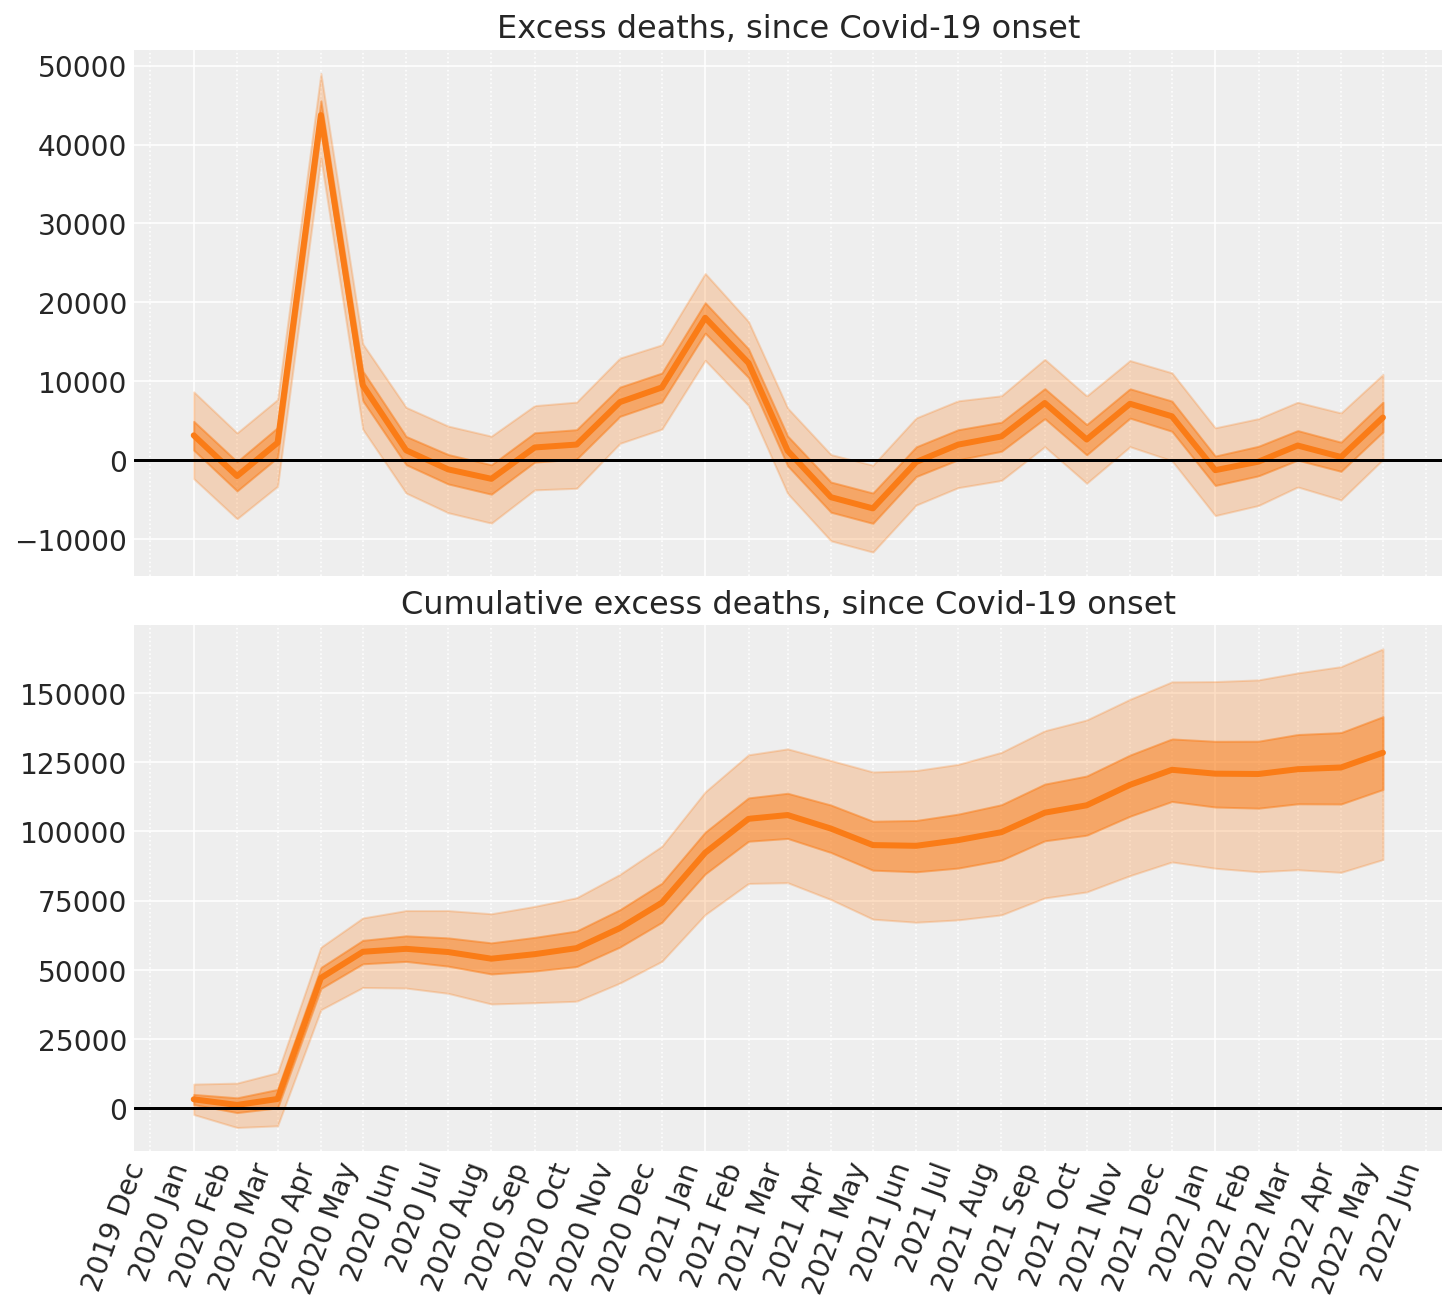

In [27]:
fig, ax = plt.subplots(2, 1, figsize=(figsize[0], 9), sharex=True)

# Plot the excess deaths
# The transpose is to keep arviz happy, ordering the dimensions as (chain, draw, t)
plot_xY(post.index, excess_deaths.transpose(..., "t"), ax[0])
format_x_axis(ax[0], minor=True)
ax[0].axhline(y=0, color="k")
ax[0].set(title="Excess deaths, since Covid-19 onset")

# Plot the cumulative excess deaths
plot_xY(post.index, cumsum.transpose(..., "t"), ax[1])
format_x_axis(ax[1], minor=True)
ax[1].axhline(y=0, color="k")
ax[1].set(title="Cumulative excess deaths, since Covid-19 onset");

And there we have it - we've done some Bayesian counterfactual inference in PyMC! In just a few steps we've:
- Built a simple linear regression model.
- Inferred the model parameters based on pre Covid-19 data, running prior and posterior predictive checks. We note that the model is pretty good, but as always there might be ways to improve the model in the future.
- Used the model to create counterfactual predictions of what would happen in the future (Covid-19 era) if nothing had changed.
- Calculated the excess deaths (and cumulative excess deaths) by comparing the reported deaths to our counterfactual expected number of deaths.

The bad news of course, is that as of the last data point (May 2022) the number of excess deaths in England and Wales has started to rise again.

## References

:::{bibliography}
:filter: docname in docnames
:::

## Authors
- Authored by [Benjamin T. Vincent](https://github.com/drbenvincent) in July 2022.

## Watermark

In [28]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,aeppl,xarray

Last updated: Sat Jul 02 2022

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.4.0

aesara: 2.6.6
aeppl : 0.0.31
xarray: 2022.3.0

numpy     : 1.21.6
seaborn   : 0.11.2
aesara    : 2.6.6
pymc      : 4.0.0
arviz     : 0.12.1
matplotlib: 3.5.2
xarray    : 2022.3.0
pandas    : 1.4.2

Watermark: 2.3.1



:::{include} ../page_footer.md
:::